In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
import scipy.io
npr.seed(0)

import ssm
from ssm.util import find_permutation, split_by_trials
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib notebook

# import seaborn as sns
# sns.set_style("white")
# sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

# colors = sns.xkcd_palette(color_names)
# cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = True

%reload_ext autoreload
%autoreload 2

In [2]:
# Set the parameters of the HMM
time_bins = 300   # number of time bins
num_states = 3    # number of discrete states
obs_dim = 10       # dimensionality of observation

# Make an HMM
true_hmm = ssm.HMM(num_states, obs_dim, observations="block")

true_hmm.observations.mus = np.array([1, 4, 9]).T
true_hmm.observations.sigmas = np.array([0.8, 0.8, 0.8]).T

# Sample some data from the HMM
true_states, obs = true_hmm.sample(time_bins)
# true_ll = true_hmm.log_probability(obs)

arr=  true_hmm.observations.log_likelihoods(obs, None, None, None)

<IPython.core.display.Javascript object>


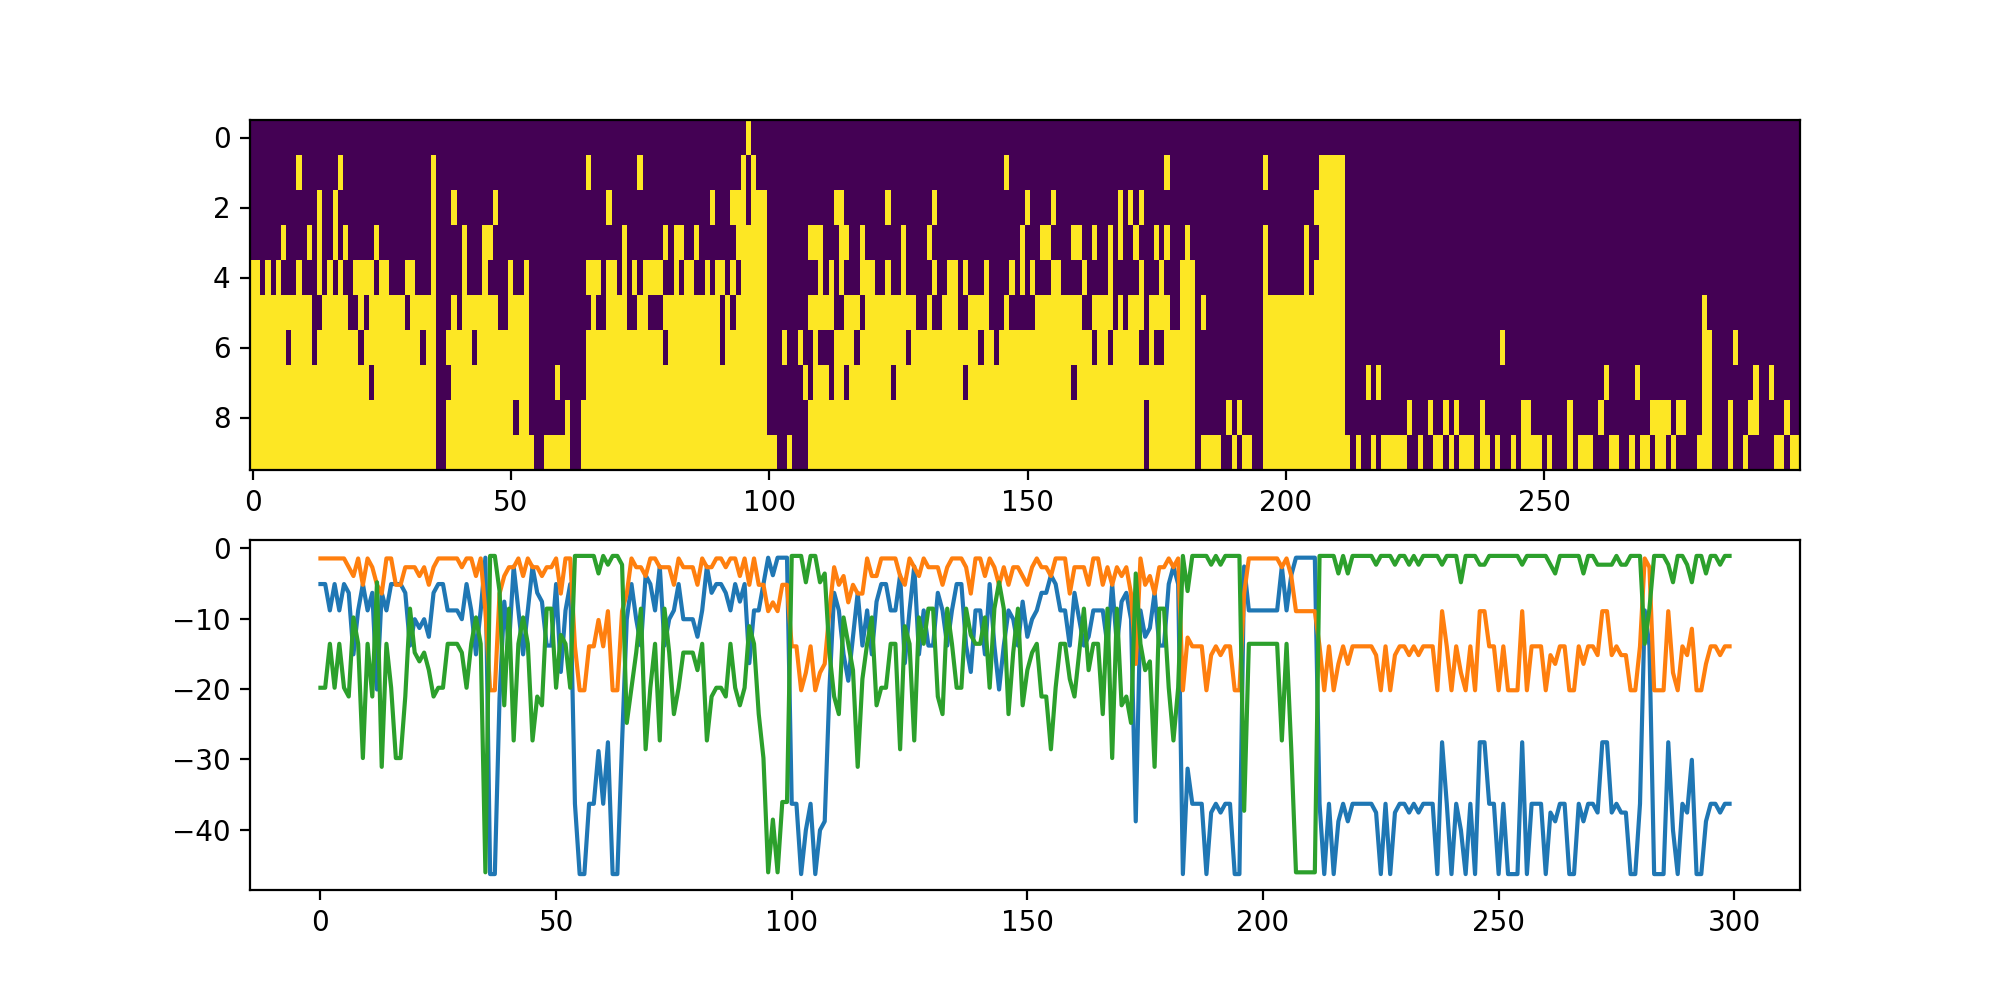

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.imshow(obs.T, aspect='auto')
plt.subplot(212)
plt.plot(arr)

In [4]:
data = obs # Treat observations generated above as synthetic data.
N_iters = 5000

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="block")

hmm_lls = hmm.fit(obs, method="sgd", num_iters=N_iters, init_method="kmeans")

plt.plot(hmm_lls, label="EM")
# plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

/Users/minhnhatle/Documents/ExternalCode/ssm/ssm/observations.py:130: RuntimeWarning: divide by zero encountered in true_divide
  yvals = 1 / (1 + np.exp(-(xvals - mu) / sigma))
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in true_divide
  return f_raw(*args, **kwargs)
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: divide by zero encountered in true_divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/autograd/numpy/numpy_vjps.py:78: RuntimeWarning: invalid value encountered in true_divide
  defvjp(anp.log,    lambda ans, x : lambda g: g / x)
/Users/minhnhatle/opt/a

  0%|          | 0/5000 [00:00<?, ?it/s]

In [5]:
hmm.observations.params

(array([[-0.97185743],
        [ 9.05519339],
        [ 4.17198938]]),
 array([[1.76848019],
        [0.81963405],
        [0.89745191]]))

In [6]:
true_hmm.observations.params

(array([1, 4, 9]), array([0.8, 0.8, 0.8]))

In [7]:
find_permutation(np.array([0,1,2,2]), np.array([2,1,1,1]))

array([2, 0, 1])

In [8]:
most_likely_states = hmm.most_likely_states(obs)
hmm.permute(find_permutation(true_states, most_likely_states))

<IPython.core.display.Javascript object>


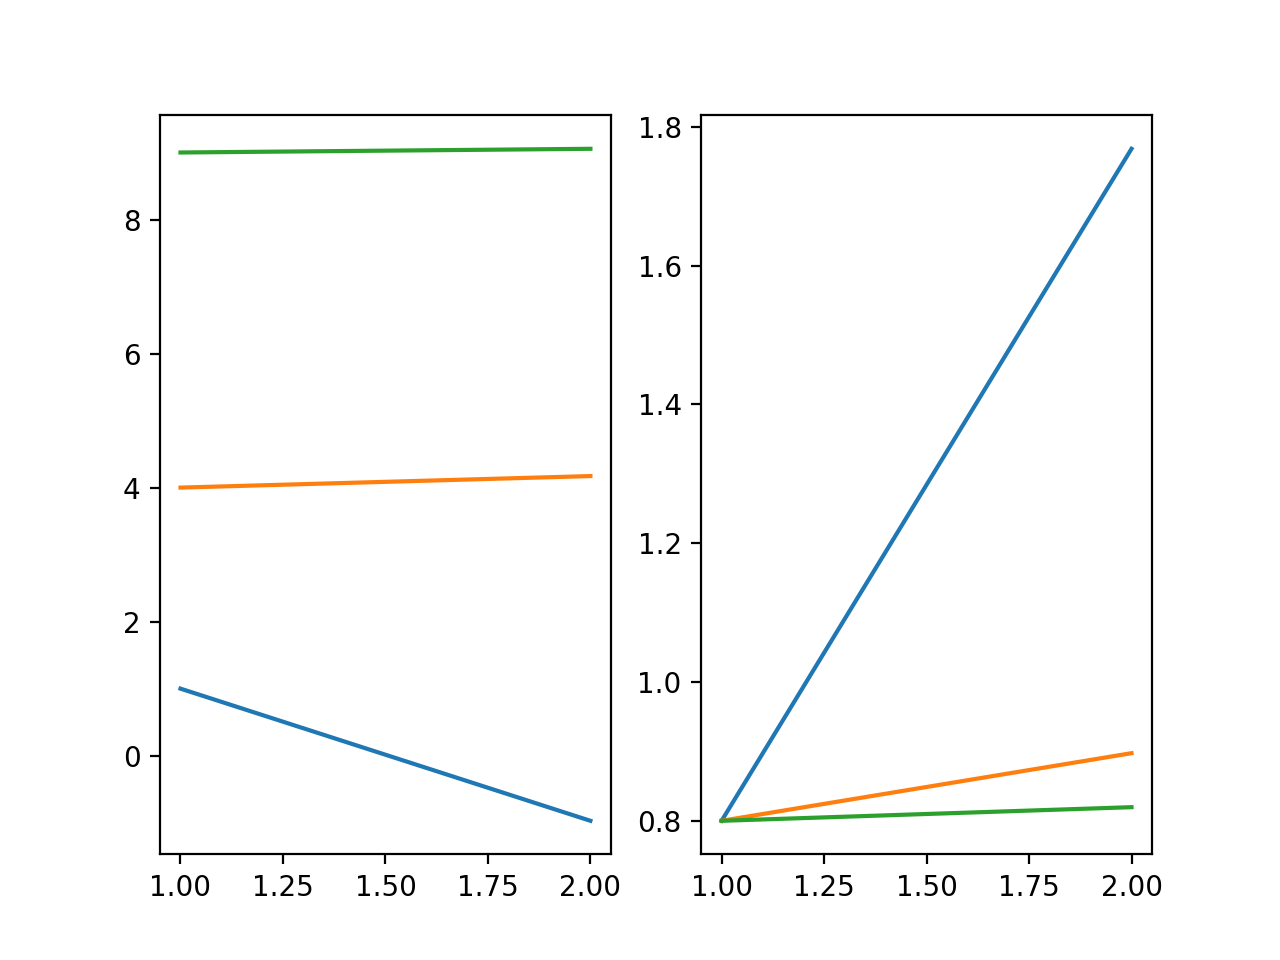

/Users/minhnhatle/opt/anaconda3/envs/default/lib/python3.9/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


In [14]:
# Comparing the true and inferred parameters
true_mus, true_sigmas = true_hmm.observations.params
sim_mus, sim_sigmas = hmm.observations.params


plt.figure()
plt.subplot(121)
for i in range(3):
    plt.plot([1,2], [true_mus[i], sim_mus[i]])
    
plt.subplot(122)
for i in range(3):
    plt.plot([1,2], [true_sigmas[i], sim_sigmas[i]])

In [110]:
learned_transition_mat

array([[1.25177208e-02, 1.48346513e-02, 9.72647628e-01],
       [1.97515289e-32, 6.34862552e-01, 3.65137448e-01],
       [2.71227471e-01, 3.72005646e-01, 3.56766884e-01]])

<IPython.core.display.Javascript object>


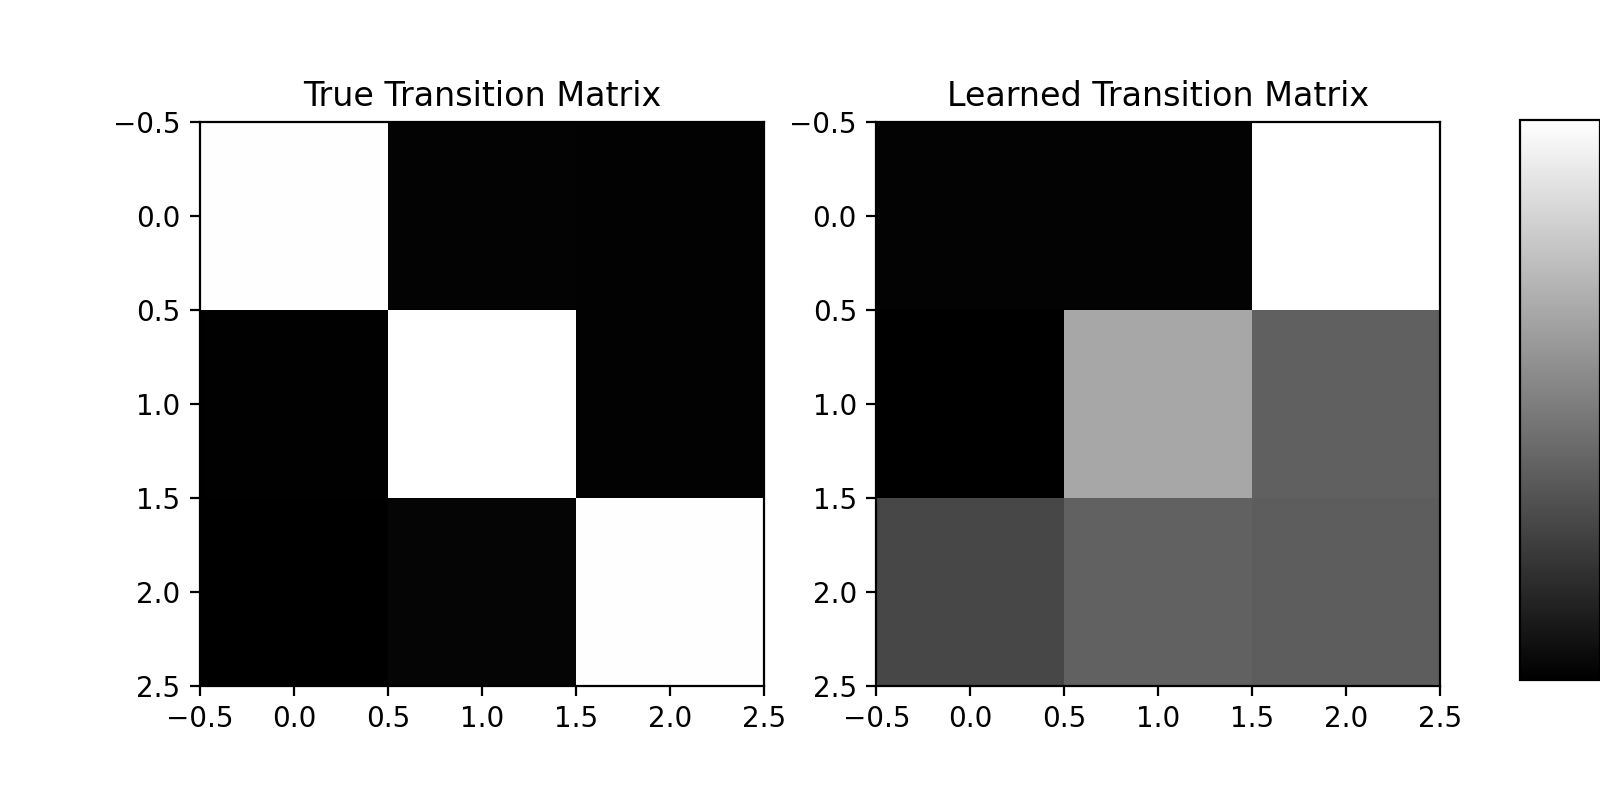

In [109]:
# Note: rows correspond to origin state, columns are destinations
# so that (i,j) entry corresponds to P(z_t+1 = j | z_t = i)
true_transition_mat = true_hmm.transitions.transition_matrix
learned_transition_mat = hmm.transitions.transition_matrix

fig = plt.figure(figsize=(8, 4))
plt.subplot(121)
im = plt.imshow(true_transition_mat, cmap='gray')
plt.title("True Transition Matrix")

plt.subplot(122)
im = plt.imshow(learned_transition_mat, cmap='gray')
plt.title("Learned Transition Matrix")

cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


## Fit to animal behavior

In [87]:
def load_session(filepath, id):
    data = scipy.io.loadmat(filepath)
    choices = data['choices_cell'][0][id][0].astype('float')
    targets = data['targets_cell'][0][id][0].astype('float')

    # flip choices for targets = 0
    signedtargets = 1 - 2 * targets
    signedchoices = (choices * signedtargets + 1) / 2


    bpos = np.where(np.diff(targets))
    bpos = np.hstack([-1, bpos[0], len(targets) - 1])
    blens = np.diff((bpos))
    # blens = np.hstack([bpos[0][0] + 1, blens])
    counters = np.hstack(list(map(lambda x: np.arange(x), blens)))

    choicearr = split_by_trials(signedchoices, blens, chop='max')[:,:15]
    #choicearr[::2,:] = 1 - choicearr[::2,:]
    # choicearr = (choicearr + 1) / 2

    choicearr[np.isnan(choicearr)] = 0
    choicearr[choicearr == 0.5] = 1

    blocktargets = targets[bpos[1:]]


    return choicearr, blocktargets
    



In [90]:
def load_multiple_sessions(filepath, idlst):
    '''
    filepath: path to extracted data .mat file
    idlst: list of sessions to extract
    returns: concatenated choice, num trials of sessions
    '''
    choicearrs = [load_session(filepath, id)[0] for id in idlst]
    blocktargets = [load_session(filepath, id)[1] for id in idlst]
    blocktargets = np.hstack(blocktargets)
#     choicearrs = list(map(lambda x: load_session(filepath, x), idlst))
    
    return np.vstack(choicearrs), [arr.shape[0] for arr in choicearrs], blocktargets
    
    



<IPython.core.display.Javascript object>


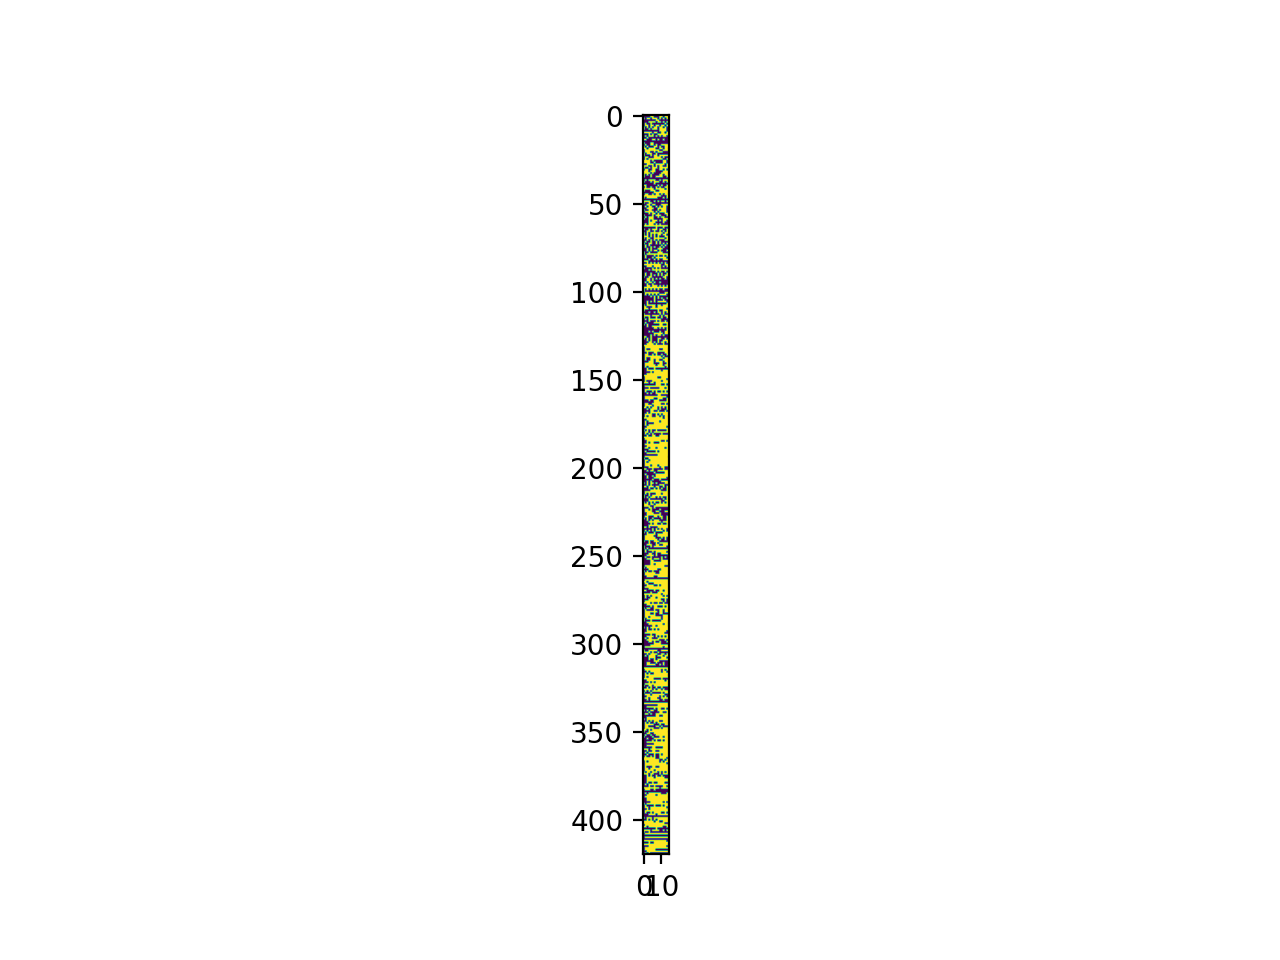

In [104]:
#TODOs:
# -Handle nan choices
# - Faster optimization and avoid local minima?

# Load data
filepath = '/Users/minhnhatle/Dropbox (MIT)/Sur/MatchingSimulations/expdata/f02_all_sessions.mat'
# obs = load_session(filepath, 28)
obs, lengths, dirs = load_multiple_sessions(filepath, np.arange(7,35))
plt.imshow(choicearr)

plt.figure()
plt.imshow(obs)

In [111]:
mus

array([[ 5.45452016],
       [62.88943156],
       [ 0.        ]])

In [112]:
sigmas

array([[  5.58480703],
       [128.49561252],
       [  4.58278491]])

  0%|          | 0/1000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


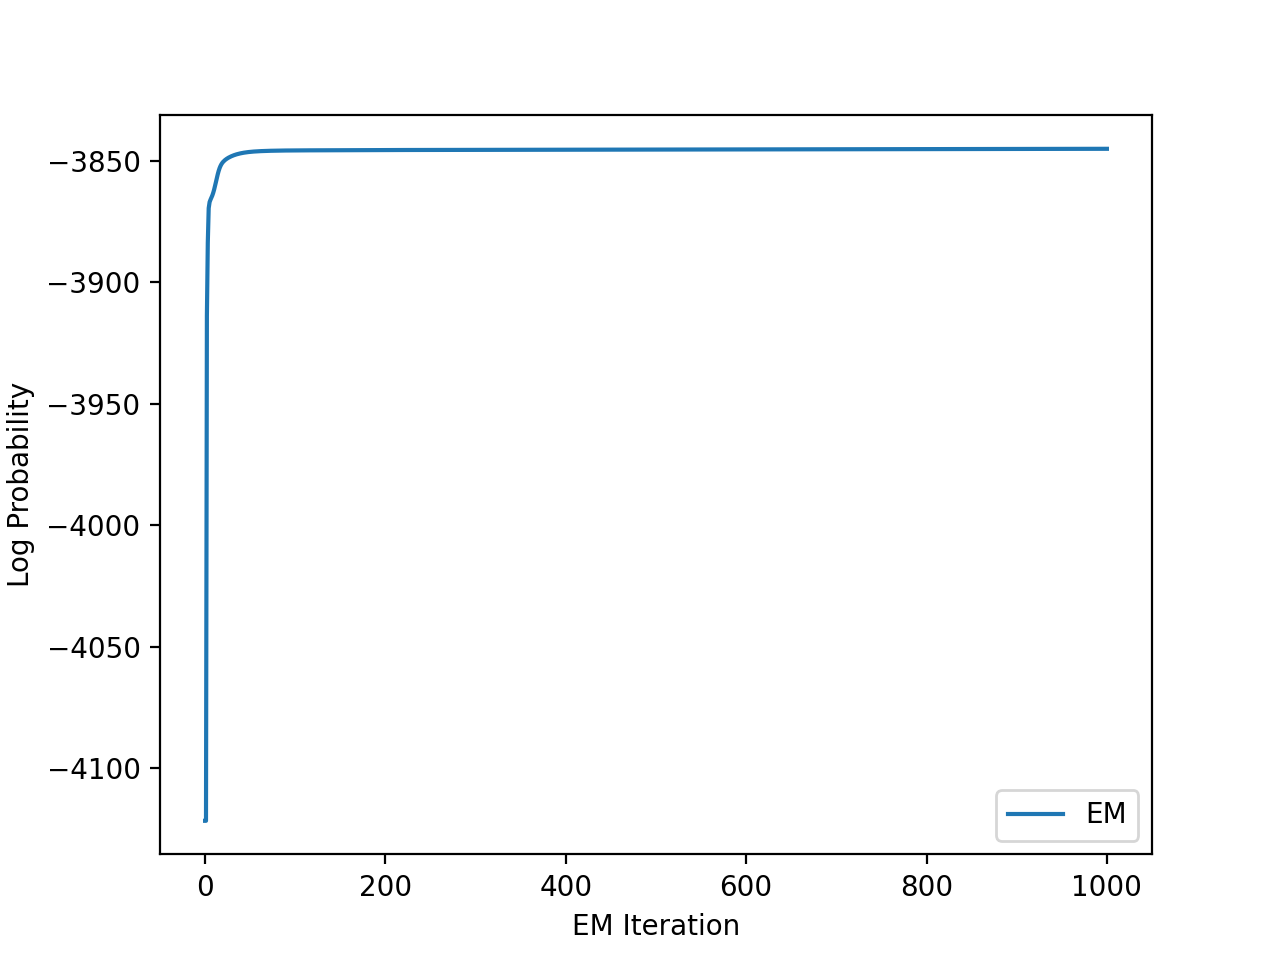

In [105]:
N_iters = 1000
obs_dim = obs.shape[1]

## testing the constrained transitions class
hmm = ssm.HMM(num_states, obs_dim, observations="block")

hmm_lls = hmm.fit(obs, method="em", num_iters=N_iters, init_method="kmeans")

plt.figure()
plt.plot(hmm_lls, label="EM")
# plt.plot([0, N_iters], true_ll * np.ones(2), ':k', label="True")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

<IPython.core.display.Javascript object>


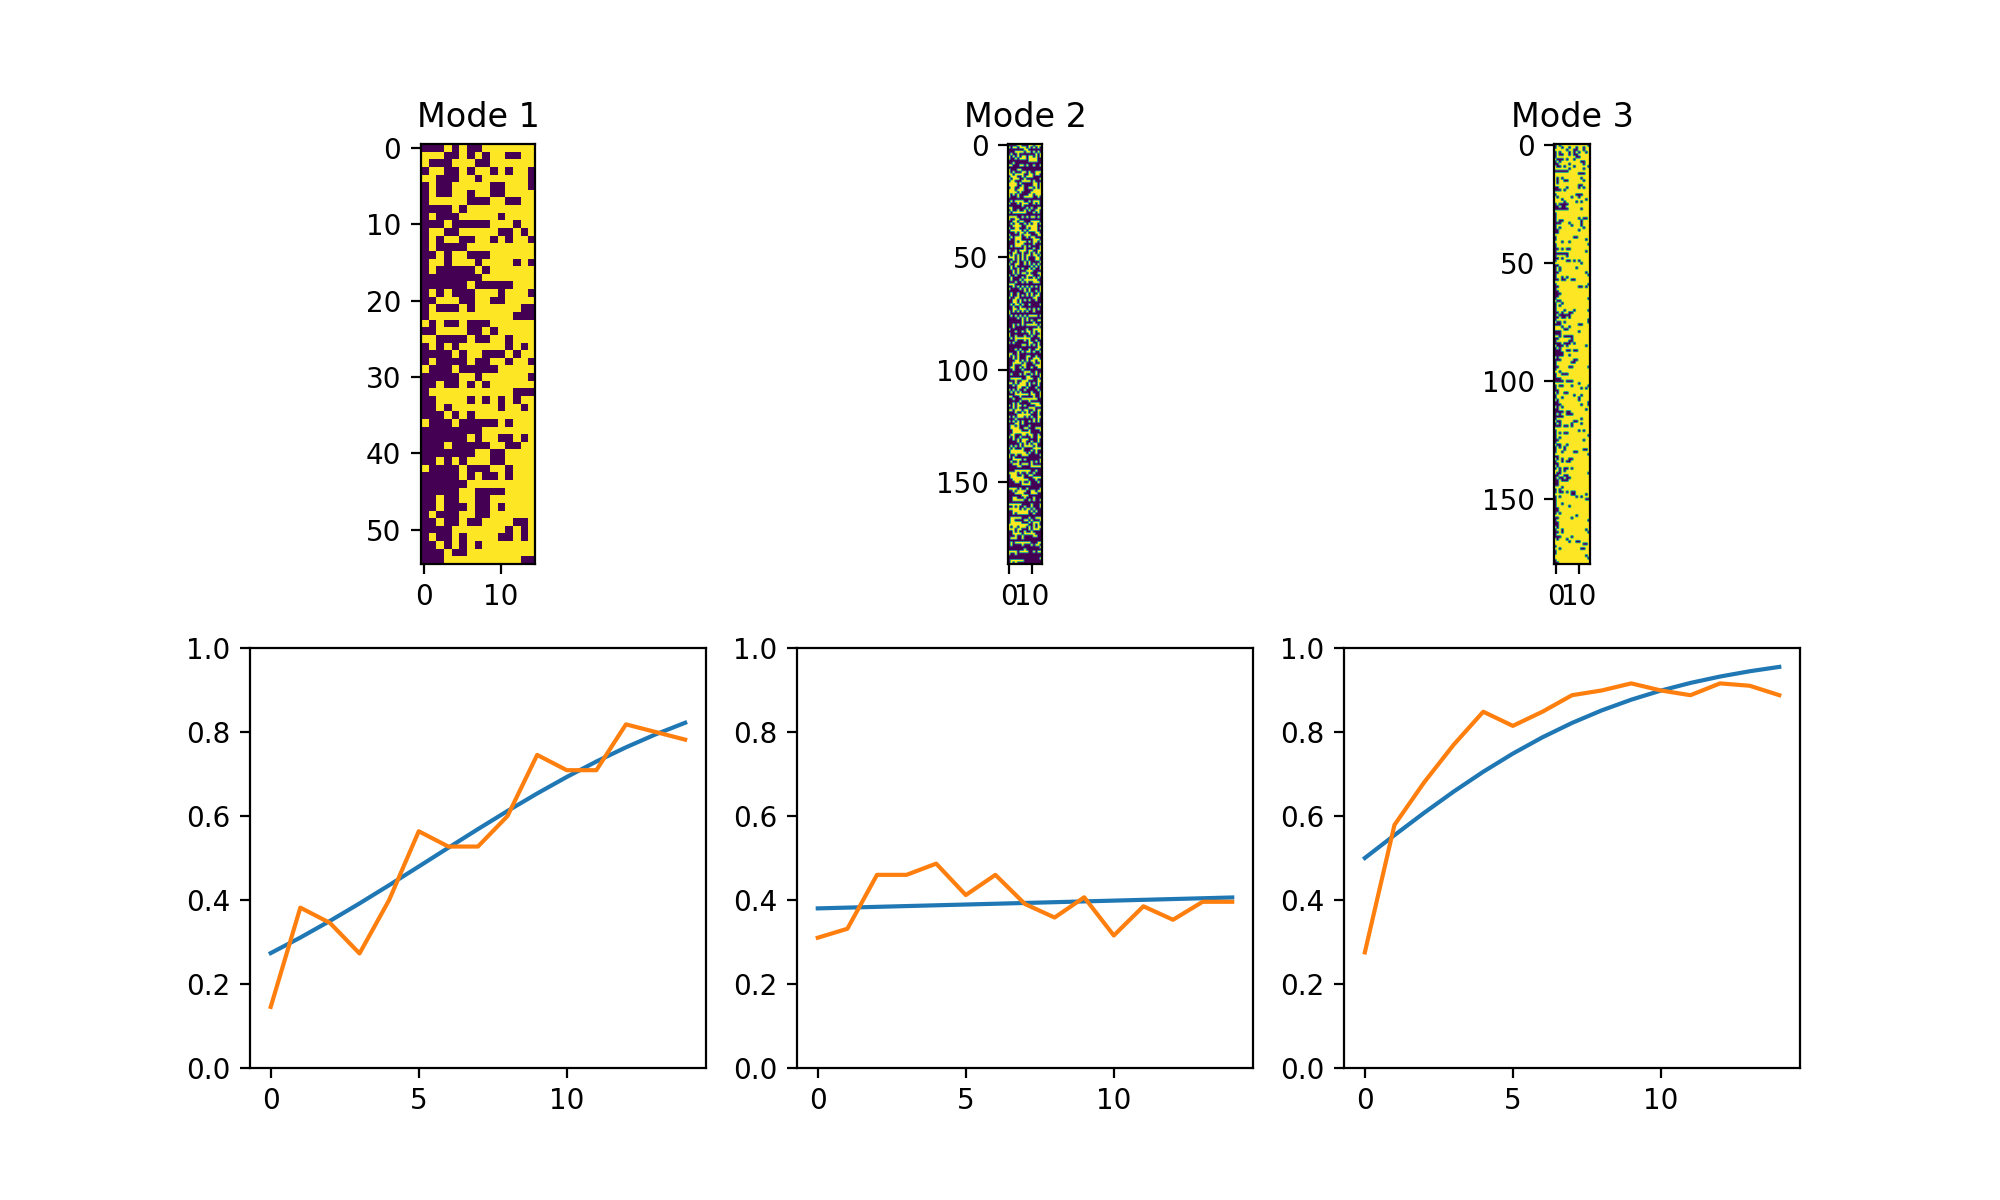

(0.0, 1.0)

In [114]:
def sigmoid(x, mu, sigma):
    return 1 / (1 + np.exp(-(x - mu) / sigma))

# Pool states and visualize
zstates = hmm.most_likely_states(obs)
obs_clustered = list(map(lambda x: obs[(zstates == x),:], np.unique(zstates)))

# Construct the block transition function for each mode
mus, sigmas = hmm.observations.params

transfuncs = list(map(lambda mu,sigma: sigmoid(np.arange(15), mu, sigma), mus, sigmas))


plt.figure(figsize=(10,6))
plt.subplot(231)
plt.imshow(obs_clustered[0])
plt.title('Mode 1')


plt.subplot(232)
plt.imshow(obs_clustered[1])
plt.title('Mode 2')


plt.subplot(233)
plt.imshow(obs_clustered[2])
plt.title('Mode 3')


plt.subplot(234)
plt.plot(transfuncs[0])
plt.plot(np.nanmean(obs_clustered[0], axis=0))
plt.ylim([0, 1])

plt.subplot(235)
plt.plot(transfuncs[1])
plt.plot(np.nanmean(obs_clustered[1], axis=0))
plt.ylim([0, 1])


plt.subplot(236)
plt.plot(transfuncs[2])
plt.plot(np.nanmean(obs_clustered[2], axis=0))
plt.ylim([0, 1])



<IPython.core.display.Javascript object>


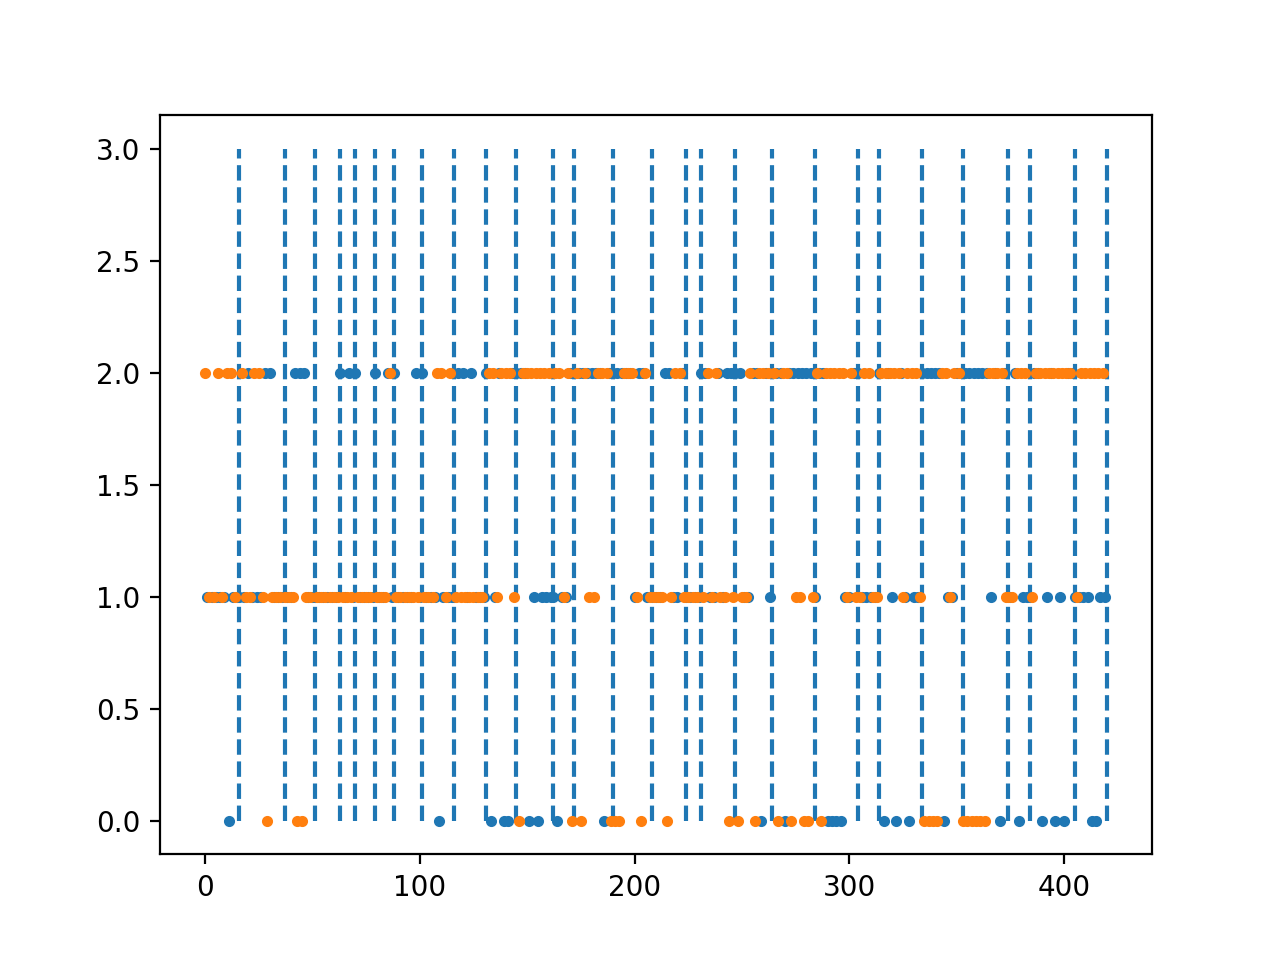

In [108]:
plt.figure()
pos = np.arange(len(zstates))
plt.plot(pos[dirs == 0], zstates[dirs == 0], '.')
plt.plot(pos[dirs == 1], zstates[dirs == 1], '.')

plt.vlines(np.cumsum(lengths), 0, 3, linestyles='--')
# plt.xlim([0, 200])




## Fit to multiple sessions

In [ ]:
load_session(filepath, 28)

In [ ]:
id = 30
data = scipy.io.loadmat(filepath)
choices = data['choices_cell'][0][id][0].astype('float')
targets = data['targets_cell'][0][id][0].astype('float')

signedtargets = targets * 2 - 1
signedchoices = (choices * signedtargets + 1) / 2


bpos = np.where(np.diff(targets))
bpos = np.hstack([-1, bpos[0], len(targets) - 1])
blens = np.diff((bpos))
# blens = np.hstack([bpos[0][0] + 1, blens])
counters = np.hstack(list(map(lambda x: np.arange(x), blens)))

choicearr = split_by_trials(signedchoices, blens, chop='max')[:,:15]
choicearr[1::2,:] *= -1
choicearr = (choicearr + 1) / 2

choicearr[np.isnan(choicearr)] = 0
choicearr[choicearr == 0.5] = 1

In [ ]:
arr, lengths = load_multiple_sessions(filepath, np.arange(25,35))

In [ ]:
lengths

In [ ]:
plt.imshow(arr)